# Conformal prediction for wind speed forecasting
This notebook goes through the training and testing of conformal predictors for wind speed forecasting as well as a Quantile Random Forest regressor for reference. 

In [1]:
import numpy as np
from data.dataimport import dataimport
from models.conformal_nex import Conformal_nex
from models.conformal_nxg import Conformal_nxg
from models.conformal_std import Conformal_std
from models.forest_qr import RanForestQuantile
import matplotlib.pyplot as plt
from mod_tr_schedule import train_schedule

## Training schedule
We use a training schedule for testing the models. It works by splitting the data into a number of different trianing / validation data configurations. It then runs each desired model through all configurations. The one making the best predictions on the validation data will be trained on all the data before making the next prediction. The prediction is saved as a result before the corresponding data point is added to the training set and the process is ran again. This tries to mimic what one would actually do in the real world, meaning that each test point can be predicted with different hyper-parameters. The data splitting and model choice implementations can be found in `mod_tr_schedule.py` for a detailed view. However in general it works in the following:
1. Number of splits $k$ and confidence-level $c$ is passed together with data and model (parameters)
2. For each set of model-parameters
    1. Train model on $\frac{1}{1-c} + 1$ points to esnure non-infinite prediciton
    2. Predict the value of every $k$:th point and train the model in between
    3. Shift the points to predict with 1 and run through data-set again
    4. Repeat until the model has run through the training-set $k$ times
3. Determine which set of model-parameters performs best on the validation data through some scoring scheme
4. Train that model on all the training data and predict the next test-point
5. Add the prediction as a result and add the next test-point to the training set
6. Repeat for all test-points

The scoring scheme $S$ currently implemented is 

$S(M,X,Y) = a|c - \frac{1}{n} \sum_{i=1}^{n} \mathbb{1}_{M(X_i)}(Y_i)| + b \frac{1}{n} w(M(X_i))$ 

where $M$ is the model with inputs $X$, labels $Y$, validation-point indicies $i \in [1,n]$. The function $w(x)$ represents the width of interval/set $x$. The parameters $a$ and $b$ are currently chosen as $1000$ and $1$ respectively.

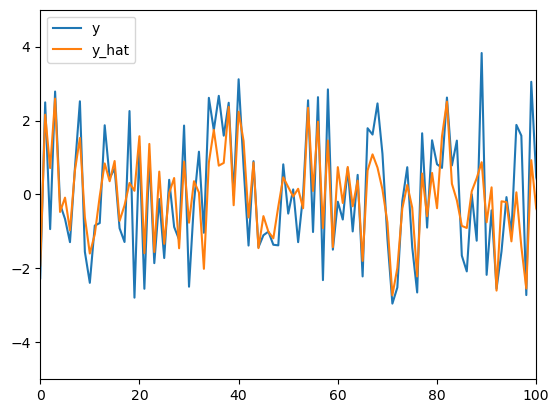

In [4]:
num_training = 100
num_testing = 700
noise_vec = np.random.normal(0,1,(num_training+num_testing,3))
pol = np.array([1, -0.5])
y_train, y_test = noise_vec[:num_training,:2] @ pol + noise_vec[:num_training,2], noise_vec[num_training:,:2] @ pol + noise_vec[num_training:,2]
x_train, x_test = noise_vec[:num_training,:2], noise_vec[num_training:,:2]
yhat_train, yhat_test = noise_vec[:num_training,:2] @ pol, noise_vec[num_training:,:2] @ pol
plt.plot(y_test, label = 'y')
plt.plot(yhat_test, label = 'y_hat')
plt.axis([0,100,-5,5])
plt.legend()


In [5]:
mod_params = [{'forget_factor':0.99}, {'forget_factor':0.98}, {'forget_factor':0.95}]
pred, mods = train_schedule(Conformal_nex, mod_params, x_train, yhat_train, y_train, x_test, yhat_test, y_test, num_splits=5, confidence=0.9)
print("Accuracy: " + str(np.sum((np.squeeze(y_test) > pred[:,0]) & (np.squeeze(y_test) < pred[:,1]))/len(y_test)))
print("Mean width: " + str(np.mean(pred[:,1]-pred[:,0])))

100%|██████████| 700/700 [01:18<00:00,  8.88it/s]

Accuracy: 0.9085714285714286
Mean width: 3.3017163947531936


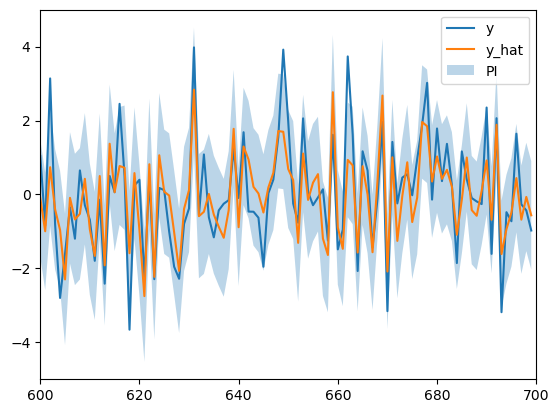

In [9]:
plt.plot(y_test, label = 'y')
plt.plot(yhat_test, label = 'y_hat')
plt.fill_between(range(len(y_test)),pred[:,0], y2 = pred[:,1], alpha = 0.3, label = 'PI')
plt.axis([num_testing-100,num_testing,-5,5])
plt.legend()

100%|██████████| 700/700 [01:25<00:00,  8.20it/s]

Accuracy: 0.9071428571428571
Mean width: 3.34124537460835


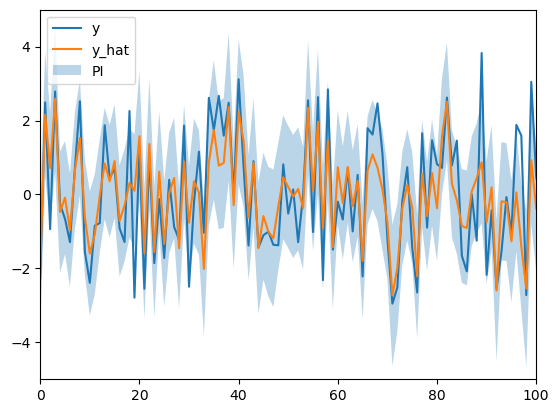

In [7]:
mod_params = [{'forget_factor':0.99, 'resid_factor':0.8, 'input_factor': np.array([0.1]), 'num_input_vars':1}, {'forget_factor':0.98, 'resid_factor':0.8, 'input_factor': np.array([0.1]),'num_input_vars':1}]
pred1, mods = train_schedule(Conformal_nxg, mod_params, x_train, yhat_train, y_train, x_test, yhat_test, y_test, num_splits=5, confidence=0.9)
print("Accuracy: " + str(np.sum((np.squeeze(y_test) > pred1[:,0]) & (np.squeeze(y_test) < pred1[:,1]))/len(y_test)))
print("Mean width: " + str(np.mean(pred1[:,1]-pred1[:,0])))

plt.plot(y_test, label = 'y')
plt.plot(yhat_test, label = 'y_hat')
plt.fill_between(range(len(y_test)),pred1[:,0], y2 = pred1[:,1], alpha = 0.3, label = 'PI')
plt.axis([num_testing-100,num_testing,-5,5])
plt.legend()

In [3]:
mod_params = [{'window_length':np.inf}]
pred, mods = train_schedule(Conformal_std, mod_params, x_train, np.expand_dims(yhat_train,1), np.expand_dims(y_train,1), x_test, np.expand_dims(yhat_test,1), np.expand_dims(y_test,1), num_splits=5, confidence=0.9)
print("Accuracy: " + str(np.sum((np.squeeze(y_test) > pred[:,0]) & (np.squeeze(y_test) < pred[:,1]))/len(y_test)))
print("Mean width: " + str(np.mean(pred[:,1]-pred[:,0])))

100%|██████████| 400/400 [09:04<00:00,  1.36s/it]

Accuracy: 0.88
Mean width: 3.6052916958805974


In [ ]:
# Import the data
inp_data, forecasts, measurements, fcdates = dataimport()

In [ ]:
conf_nex = Conformal_nex(0.99)
conf_nex.calibrate(inp_data[0],forecasts[0],measurements[0])
pred = np.empty((len(forecasts[1]),2))
for i in range(len(forecasts[1])):
    pred[i,:] = conf_nex.predict(inp_data[1][i,:],forecasts[1][i])
print(str(np.sum((np.squeeze(measurements[1]) > pred[:,0]) & (np.squeeze(measurements[1]) < pred[:,1]))/len(forecasts[1])))

In [ ]:
conf_std = Conformal_std()
conf_std.calibrate(inp_data[0],forecasts[0],measurements[0])
pred = np.empty((len(forecasts[1]),2))
for i in range(len(forecasts[1])):
    pred[i,:] = conf_std.predict(inp_data[1][i,:],forecasts[1][i])
print(str(np.sum((np.squeeze(measurements[1]) > pred[:,0]) & (np.squeeze(measurements[1]) < pred[:,1]))/len(forecasts[1])))

In [ ]:
conf_nxg = Conformal_nxg(0.98, 0.95, np.array([0.01, 0.01]), 2)
conf_nxg.calibrate(inp_data[0],forecasts[0],measurements[0])
pred = np.empty((len(forecasts[1]),2))
for i in range(len(forecasts[1])):
    pred[i,:] =conf_nxg.predict(inp_data[1][i,:],forecasts[1][i])
print(str(np.sum((np.squeeze(measurements[1]) > pred[:,0]) & (np.squeeze(measurements[1]) < pred[:,1]))/len(forecasts[1])))

In [ ]:
fqr = RanForestQuantile()
fqr.calibrate(inp_data[0],forecasts[0],measurements[0])
pred = np.empty((len(forecasts[1]),2))
for i in range(len(forecasts[1])):
    pred[i,:] =fqr.predict(inp_data[1][i,:],forecasts[1][i])
print(str(np.sum((np.squeeze(measurements[1]) > pred[:,0]) & (np.squeeze(measurements[1]) < pred[:,1]))/len(forecasts[1])))

In [ ]:
conf_nex = Conformal_nex(0.99)
conf_nex.calibrate(inp_data[0][:20],forecasts[0][:20],measurements[0][:20])
conf_nex.calibrate(inp_data[0][20:],forecasts[0][20:],measurements[0][20:])


In [ ]:
mod_params = [{'forget_factor':0.99}, {'forget_factor':0.98}, {'forget_factor':0.95}]
pred, mods = train_schedule(Conformal_nex, mod_params, inp_data[0], forecasts[0], measurements[0], inp_data[1], forecasts[1], measurements[1], num_splits=5, confidence=0.9)
print(np.sum((np.squeeze(measurements[1]) > pred[:,0]) & (np.squeeze(measurements[1]) < pred[:,1]))/len(measurements[1]))
print(np.mean(pred[:,1]-pred[:,0]))

In [ ]:
plt.plot(measurements[1])
plt.fill_between(range(len(measurements[1])),pred[:,0], y2 = pred[:,1], alpha = 0.3)

In [ ]:
mod_params = [{'forget_factor':0.99, 'resid_factor':0.95, 'input_factor': np.array([0.01, 0.01]), 'num_input_vars':2}, {'forget_factor':0.98, 'resid_factor':0.95, 'input_factor': np.array([0.01, 0.01]),'num_input_vars':2}]
pred, mods = train_schedule(Conformal_nxg, mod_params, inp_data[0], forecasts[0], measurements[0], inp_data[1], forecasts[1], measurements[1], num_splits=5, confidence=0.9)
print(np.sum((np.squeeze(measurements[1]) > pred[:,0]) & (np.squeeze(measurements[1]) < pred[:,1]))/len(measurements[1]))
print(np.mean(pred[:,1]-pred[:,0]))

In [ ]:
plt.plot(measurements[1])
plt.fill_between(range(len(measurements[1])),pred[:,0], y2 = pred[:,1], alpha = 0.3)

In [ ]:
mod_params = [{'window_length':np.inf}, {'window_length':50}]
pred, mods = train_schedule(Conformal_std, mod_params, inp_data[0], forecasts[0], measurements[0], inp_data[1], forecasts[1], measurements[1], num_splits=5, confidence=0.9)
print(np.sum((np.squeeze(measurements[1]) > pred[:,0]) & (np.squeeze(measurements[1]) < pred[:,1]))/len(measurements[1]))
print(np.mean(pred[:,1]-pred[:,0]))

In [ ]:
plt.plot(measurements[1])
plt.fill_between(range(len(measurements[1])),pred[:,0], y2 = pred[:,1], alpha = 0.3)

In [ ]:
mod_params = [{'num_trees':100,'window_length':np.inf}, {'num_trees':80,'window_length':50}]
pred, mods = train_schedule(RanForestQuantile, mod_params, inp_data[0], forecasts[0], measurements[0], inp_data[1], forecasts[1], measurements[1], num_splits=5, confidence=0.9)

In [ ]:
plt.plot(measurements[1])
plt.fill_between(range(len(measurements[1])),pred[:,0], y2 = pred[:,1], alpha = 0.3)

In [ ]:
print(np.sum((np.squeeze(measurements[1]) > pred[:,0]) & (np.squeeze(measurements[1]) < pred[:,1]))/len(measurements[1]))